
# Modeling Downwelling IR Spectrum from a Supercooled Liquid Cloud for Temperature Independent and Dependent CRIs
### Ash Gilbert
### ATOC 5235 Final Project

## Introduction & Motivation
The complex refractive index (CRI) of liquid water has a temperature dependence for supercooled liquid water. The CRIs for liquid water used in climate models are measured at room temperature and thus do not account for this temperature dependence. For clouds with a significant fraction of supercooled liquid water, this can affect how much downwelling flux the cloud emits. Arctic clouds are mostly mixed-phase clouds that contain supercooled liquid water and their modeled emission may be affected by using temperature independent CRIs. Prior case studies from Antarctica have shown that clouds modeled with temperature dependent CRI emit more downwelling infrared radiation than those with temperature independent CRI. In summary, climate models may be underestimating infrared cloud emission by using temperature independent CRIs and thus introducing biases into the Arctic energy budget and surface temperature.

I propose a study of the effect of supercooled liquid water CRI on the downwelling radiation from a simulated Arctic cloud, using a two-stream radiative transfer model. I will compare the downwelling infrared spectra in the atmospheric window (770-1000 cm-1) from three sets of liquid water CRIs (Downing & Williams 300 K, Segelstein 282 K, Rowe 240 K, 253 K, 263 K, 273K) for a single liquid-phase cloud at different temperatures (240 K, 253 K, 263 K, 273K). I will also test the effects of varying the thickness and type of cloud (monodisperse or polydisperse), but I will hold the reff constant at 10 µm. I will assume Mie scattering, a two-stream radiative transfer, and a non-black surface.  

## Methods
### Equations
Polydisperse cloud:
$$
\alpha = 3
$$

$$
n(r) = ar^{\alpha}exp(-br)
$$

$$
r_{eff} = \frac{\alpha+3}{b} = 10 \text{ }\mu\text{m}
$$ 

$$
N = a\frac{\alpha!}{b^{\alpha+1}} = 40 \text{ cm}^{-3}
$$

$$
\beta_{e} = \int_{0}^{r} n(r)Q_{ext}\pi r^2 dr
$$

$$
Q_{ext} = \frac{1}{N}\int_{0}^{r} n(r) Q_{ext} dr
$$

$$
g = \frac{1}{N}\int_{0}^{r} n(r) g dr
$$

$$
\tilde{\omega} = \frac{1}{N}\int_{0}^{r} n(r) \tilde{\omega} dr
$$

The first four equations describe the number distribution for the polydisperse cloud. The next four equations describe how $\beta_{e}$, $Q_{ext}$, g, and $\tilde{\omega}$ are averaged over the number distribution for the polydisperse cloud.

Radiation equations:
$$
\tau^{*} = \beta_{e}\Delta Z_{cld}
$$

$$
\Gamma = 2\sqrt{1-\tilde{\omega}}\sqrt{1-\tilde{\omega}g}
$$

$$
r_{\infty} = \frac{\sqrt{1-\tilde{\omega}g}-\sqrt{1-\tilde{\omega}}}{\sqrt{1-\tilde{\omega}g}+\sqrt{1-\tilde{\omega}}}
$$

$$
r \text{(black surface)} = \frac{r_{\infty}[e^{\Gamma \tau^{*}}-e^{-\Gamma \tau^{*}}]}{e^{\Gamma \tau^{*}}-r_{\infty}^2 e^{-\Gamma \tau^{*}}} 
$$

$$
t \text{(black surface)} = \frac{1-r_{\infty}^2}{e^{\Gamma \tau^{*}}-r_{\infty}^2 e^{-\Gamma \tau^{*}}}
$$

$$
r \text{(non-black surface)} = \frac{r+r_{sfc}t^2}{1-r_{sfc}r}
$$

$$
t \text{(non-black surface)} = \frac{t}{1-r_{sfc}r}
$$

$$
\varepsilon = 1-r-t
$$

$$
F_{\downarrow,\tilde{v}} = \varepsilon_{\tilde{v}} B_{\tilde{v}}(T_{cld})+r_{\tilde{v}}(1-r_{sfc})B_{\tilde{v}}(T_{sfc})
$$

The first three equations describe the variables ($\tau^{*}$, $\Gamma$, $r_{\infty}$) that will go into calculating the reflectance, transmittence, and emissitivity of the cloud. The next four equations calculate the reflectance and transmittence over black and non-black surfaces. $r_{sfc}$ is the surface albedo, which for our study is snow. The second to last equation calculates the emissivity of the cloud in terms of the reflectance and transmittence over a non-black surface. Kirchoff's Law is assumed so emissivity equals absorptivity. The last equation describes the downwelling spectral irradiance as a function of wavenumber and is calculated from the cloud emission and the surface emission reflected off the cloud.

### Coding work
Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'
import sys
import os
import miepython as mp
import textwrap
from scipy import integrate, interpolate
from IPython.display import Image

Planck function as a function of temperature and wavenumber

In [3]:
def Planck(T,wvn):
    c1 = 1.191042e-5 # mW/m2 sr cm-1\
    c2 = 1.4387752 # K cm
    return ((c1*(wvn**3))/(np.exp((c2*wvn)/(T))-1))*np.pi

In [4]:
def wvn2wvl(x):
    return 10000/x

def wvl2wvn(x):
    return 10000/x

Constants & Arrays

In [5]:
# Constants
N = 40 # cm^-3
alpha = 3
zcloud = 100 # m
reff = 10 # micron
Tsfc = 250 # K

rsfc = 0.2
poly = True # This controls whether the cloud is polydisperse (True) or monodisperse (False)
type_string = 'Poly' if poly else 'Mono'

# Arrays
wvn_range = np.arange(770,1000,1) # cm^-1
#wvn_range = np.array([10,350,500,630,700,820,980,1080,1180,1390,1480,1800,2080,2250,2380,2600,3250])
wvl_range = 10000/wvn_range # micron
r_range = np.arange(0.01,51,1) # micron
Tb_range = np.array([240,253,263,273])


# Number concentration distributions
if poly:
    b = (alpha+3)/reff
    a = (N*(b**(alpha+1)))/np.math.factorial(alpha)
    n_range = a*(r_range**alpha)*np.exp(-1*b*r_range)

/var/folders/lf/48x517g97453shvbjzhxg9rr0000gp/T/ipykernel_17916/1126137537.py:23: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  a = (N*(b**(alpha+1)))/np.math.factorial(alpha)


Load Temperature Dependent and Independent CRIs

In [6]:
# Filepaths
path_to_DWCRI = 'Water_DW_300.txt'
path_to_SegCRI = 'Segelstein.txt'
path_to_240CRI = 'water_RFN_240K.txt'
path_to_253CRI = 'water_RFN_253K.txt'
path_to_263CRI = 'water_RFN_263K.txt'
path_to_273CRI = 'water_RFN_273K.txt'

# Load in Downing & Williams 300K CRI
# Loop over the lines in the file
wvnDW = [] # cm^-1
rfrDW = [] # real part of refractive index
rfiDW = [] # imaginary part of refractive index

linesDW = open(path_to_DWCRI).readlines()

for line in linesDW[9:]: # skip first few header line
    line = bytes(textwrap.dedent(line),'utf-8')
    entries = line.decode("utf-8").split()
    if entries[0][0] != '\n':
        wvnDW.append(float(entries[0]))
        rfrDW.append(float(entries[1]))      
        rfiDW.append(float(entries[2]))

wvnDW = np.array(wvnDW)
lamDW = 10000/wvnDW
rfrDW = np.array(rfrDW)
rfiDW = np.array(rfiDW)

# Load in Segelstein 282K CRI
# Loop over the lines in the file
lamSeg = [] # micron
rfrSeg = [] # real part of refractive index
rfiSeg = [] # imaginary part of refractive index

linesSeg = open(path_to_SegCRI).readlines()

for line in linesSeg[4:]: # skip first few header line
    line = bytes(textwrap.dedent(line),'utf-8')
    entries = line.decode("utf-8").split("\t")
    if entries[0][0] != '\n':
        lamSeg.append(float(entries[0]))
        rfrSeg.append(float(entries[1]))      
        rfiSeg.append(float(entries[2]))

lamSeg = np.array(lamSeg)
wvnSeg = 10000/lamSeg
rfrSeg = np.array(rfrSeg)
rfiSeg = np.array(rfiSeg)

# Load in Rowe 240K CRI
# Loop over the lines in the file
wvn240 = [] # cm^-1
rfr240 = [] # real part of refractive index
rfi240 = [] # imaginary part of refractive index

lines240 = open(path_to_240CRI).readlines()

for line in lines240[1:]: # skip first few header line
    line = bytes(textwrap.dedent(line),'utf-8')
    entries = line.decode("utf-8").split()
    #print(entries)
    if entries[0][0] != '\n':
        wvn240.append(float(entries[0]))
        rfr240.append(float(entries[1]))      
        rfi240.append(float(entries[2]))

wvn240 = np.array(wvn240)
lam240 = 10000/wvn240
rfr240 = np.array(rfr240)
rfi240 = np.array(rfi240)

# Load in Rowe 253K CRI
# Loop over the lines in the file
wvn253 = [] # cm^-1
rfr253 = [] # real part of refractive index
rfi253 = [] # imaginary part of refractive index

lines253 = open(path_to_253CRI).readlines()

for line in lines253[1:]: # skip first few header line
    line = bytes(textwrap.dedent(line),'utf-8')
    entries = line.decode("utf-8").split()
    #print(entries)
    if entries[0][0] != '\n':
        wvn253.append(float(entries[0]))
        rfr253.append(float(entries[1]))      
        rfi253.append(float(entries[2]))

wvn253 = np.array(wvn253)
lam253 = 10000/wvn253
rfr253 = np.array(rfr253)
rfi253 = np.array(rfi253)

# Load in Rowe 263K CRI
# Loop over the lines in the file
wvn263 = [] # cm^-1
rfr263 = [] # real part of refractive index
rfi263 = [] # imaginary part of refractive index

lines263 = open(path_to_263CRI).readlines()

for line in lines263[1:]: # skip first few header line
    line = bytes(textwrap.dedent(line),'utf-8')
    entries = line.decode("utf-8").split()
    #print(entries)
    if entries[0][0] != '\n':
        wvn263.append(float(entries[0]))
        rfr263.append(float(entries[1]))      
        rfi263.append(float(entries[2]))

wvn263 = np.array(wvn263)
lam263 = 10000/wvn263
rfr263 = np.array(rfr263)
rfi263 = np.array(rfi263)

# Load in Rowe 273K CRI
# Loop over the lines in the file
wvn273 = [] # cm^-1
rfr273 = [] # real part of refractive index
rfi273 = [] # imaginary part of refractive index

lines273 = open(path_to_273CRI).readlines()

for line in lines273[1:]: # skip first few header line
    line = bytes(textwrap.dedent(line),'utf-8')
    entries = line.decode("utf-8").split()
    #print(entries)
    if entries[0][0] != '\n':
        wvn273.append(float(entries[0]))
        rfr273.append(float(entries[1]))      
        rfi273.append(float(entries[2]))

wvn273 = np.array(wvn273)
lam273 = 10000/wvn273
rfr273 = np.array(rfr273)
rfi273 = np.array(rfi273)

In [7]:
# Create 1D interpolation functions for complex refractive indices as functions of wavenumber
rfrDW_inter = interpolate.interp1d(wvnDW,rfrDW)
rfiDW_inter = interpolate.interp1d(wvnDW,rfiDW)

rfrSeg_inter = interpolate.interp1d(wvnSeg,rfrSeg)
rfiSeg_inter = interpolate.interp1d(wvnSeg,rfiSeg)

rfr240_inter = interpolate.interp1d(wvn240,rfr240)
rfi240_inter = interpolate.interp1d(wvn240,rfi240)

rfr253_inter = interpolate.interp1d(wvn253,rfr253)
rfi253_inter = interpolate.interp1d(wvn253,rfi253)

rfr263_inter = interpolate.interp1d(wvn263,rfr263)
rfi263_inter = interpolate.interp1d(wvn263,rfi263)

rfr273_inter = interpolate.interp1d(wvn273,rfr273)
rfi273_inter = interpolate.interp1d(wvn273,rfi273)

Generate Single-Scattering Parameters

In [8]:
# Single-scattering parameters for Downing & Williams
QeDW = [] # Scattering efficiency
wDW = [] # single-scattering albedo
gDW = [] # asymmetry parameter
BeDW = [] # Extinction coefficient

# Calculate Qe, w, g, Be
for i in np.arange(len(wvn_range)):
    wvn = wvn_range[i]
    wl = wvl_range[i]
    #ix = np.argmin(np.abs(wvn-wvnDW))
    rfr_i = rfrDW_inter(wvn)
    rfi_i = rfiDW_inter(wvn)
    ma  = complex(rfr_i,-rfi_i) # '-' is important
    if poly:
        xa1 = 2*np.pi*r_range/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = integrate.trapezoid(n_range*1e-12*qext*np.pi*((r_range)**2),r_range)*1e6
        qextp = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*qext,r_range) 
        w_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*(qsca/qext),r_range)
        g_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*g,r_range)
    else:   
        xa1 = 2*np.pi*reff/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = N*1e-12*(qext-qsca)*np.pi*((reff)**2)*1e6
        qextp = qext
        w_p = qsca/qext
        g_p = g
    QeDW.append(qextp)
    wDW.append(w_p)
    gDW.append(g_p)
    BeDW.append(Bep)

QeDW = np.array(QeDW)
wDW = np.array(wDW)
gDW = np.array(gDW)
BeDW = np.array(BeDW)

# Single-scattering parameters for Segelstein
QeSeg = []
wSeg = []
gSeg = []
BeSeg = []

# Calculate Qe, w, g, Be
for i in np.arange(len(wvn_range)):
    wvn = wvn_range[i]
    wl = wvl_range[i]
    #ix = np.argmin(np.abs(wvn-wvnDW))
    rfr_i = rfrSeg_inter(wvn)
    rfi_i = rfiSeg_inter(wvn)
    ma  = complex(rfr_i,-rfi_i) # '-' is important
    if poly:
        xa1 = 2*np.pi*r_range/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = integrate.trapezoid(n_range*1e-12*qext*np.pi*((r_range)**2),r_range)*1e6
        qextp = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*qext,r_range) 
        w_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*(qsca/qext),r_range)
        g_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*g,r_range)
    else:   
        xa1 = 2*np.pi*reff/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = N*1e-12*(qext-qsca)*np.pi*((reff)**2)*1e6
        qextp = qext
        w_p = qsca/qext
        g_p = g
    QeSeg.append(qextp)
    wSeg.append(w_p)
    gSeg.append(g_p)
    BeSeg.append(Bep)

QeSeg = np.array(QeSeg)
wSeg = np.array(wSeg)
gSeg = np.array(gSeg)
BeSeg = np.array(BeSeg)

# Single-scattering parameters for Rowe 240 K
Qe240 = []
w240 = []
g240 = []
Be240 = []

# Calculate Qe, w, g, Be
for i in np.arange(len(wvn_range)):
    wvn = wvn_range[i]
    wl = wvl_range[i]
    #ix = np.argmin(np.abs(wvn-wvnDW))
    rfr_i = rfr240_inter(wvn)
    rfi_i = rfi240_inter(wvn)
    ma  = complex(rfr_i,-rfi_i) # '-' is important
    if poly:
        xa1 = 2*np.pi*r_range/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = integrate.trapezoid(n_range*1e-12*qext*np.pi*((r_range)**2),r_range)*1e6
        qextp = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*qext,r_range) 
        w_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*(qsca/qext),r_range)
        g_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*g,r_range)
    else:   
        xa1 = 2*np.pi*reff/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = N*1e-12*(qext-qsca)*np.pi*((reff)**2)*1e6
        qextp = qext
        w_p = qsca/qext
        g_p = g
    Qe240.append(qextp)
    w240.append(w_p)
    g240.append(g_p)
    Be240.append(Bep)

Qe240 = np.array(Qe240)
w240 = np.array(w240)
g240 = np.array(g240)
Be240 = np.array(Be240)

# Single-scattering parameters for Rowe 253 K
Qe253 = []
w253 = []
g253 = []
Be253 = []

# Calculate Qe, w, g, Be
for i in np.arange(len(wvn_range)):
    wvn = wvn_range[i]
    wl = wvl_range[i]
    #ix = np.argmin(np.abs(wvn-wvnDW))
    rfr_i = rfr253_inter(wvn)
    rfi_i = rfi253_inter(wvn)
    ma  = complex(rfr_i,-rfi_i) # '-' is important
    if poly:
        xa1 = 2*np.pi*r_range/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = integrate.trapezoid(n_range*1e-12*qext*np.pi*((r_range)**2),r_range)*1e6
        qextp = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*qext,r_range) 
        w_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*(qsca/qext),r_range)
        g_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*g,r_range)
    else:   
        xa1 = 2*np.pi*reff/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = N*1e-12*(qext-qsca)*np.pi*((reff)**2)*1e6
        qextp = qext
        w_p = qsca/qext
        g_p = g
    Qe253.append(qextp)
    w253.append(w_p)
    g253.append(g_p)
    Be253.append(Bep)

Qe253 = np.array(Qe253)
w253 = np.array(w253)
g253 = np.array(g253)
Be253 = np.array(Be253)

# Single-scattering parameters for Rowe 263 K
Qe263 = []
w263 = []
g263 = []
Be263 = []

# Calculate Qe, w, g, Be
for i in np.arange(len(wvn_range)):
    wvn = wvn_range[i]
    wl = wvl_range[i]
    #ix = np.argmin(np.abs(wvn-wvnDW))
    rfr_i = rfr263_inter(wvn)
    rfi_i = rfi263_inter(wvn)
    ma  = complex(rfr_i,-rfi_i) # '-' is important
    if poly:
        xa1 = 2*np.pi*r_range/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = integrate.trapezoid(n_range*1e-12*qext*np.pi*((r_range)**2),r_range)*1e6
        qextp = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*qext,r_range) 
        w_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*(qsca/qext),r_range)
        g_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*g,r_range)
    else:   
        xa1 = 2*np.pi*reff/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = N*1e-12*(qext-qsca)*np.pi*((reff)**2)*1e6
        qextp = qext
        w_p = qsca/qext
        g_p = g
    Qe263.append(qextp)
    w263.append(w_p)
    g263.append(g_p)
    Be263.append(Bep)

Qe263 = np.array(Qe263)
w263 = np.array(w263)
g263 = np.array(g263)
Be263 = np.array(Be263)

# Single-scattering parameters for Rowe 273 K
Qe273 = []
w273 = []
g273 = []
Be273 = []

# Calculate Qe, w, g, Be
for i in np.arange(len(wvn_range)):
    wvn = wvn_range[i]
    wl = wvl_range[i]
    #ix = np.argmin(np.abs(wvn-wvnDW))
    rfr_i = rfr273_inter(wvn)
    rfi_i = rfi273_inter(wvn)
    ma  = complex(rfr_i,-rfi_i) # '-' is important
    if poly:
        xa1 = 2*np.pi*r_range/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = integrate.trapezoid(n_range*1e-12*qext*np.pi*((r_range)**2),r_range)*1e6
        qextp = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*qext,r_range) 
        w_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*(qsca/qext),r_range)
        g_p = (1/(N*1e-12))*integrate.trapezoid(n_range*1e-12*g,r_range)
    else:   
        xa1 = 2*np.pi*reff/wl
        qext, qsca, qback, g = mp.mie(ma,xa1) # calculations for first size parameter
        Bep = N*1e-12*(qext-qsca)*np.pi*((reff)**2)*1e6
        qextp = qext
        w_p = qsca/qext
        g_p = g
    Qe273.append(qextp)
    w273.append(w_p)
    g273.append(g_p)
    Be273.append(Bep)

Qe273 = np.array(Qe273)
w273 = np.array(w273)
g273 = np.array(g273)
Be273 = np.array(Be273)

Calculate gamma, R infinity, and cloud optical depth

In [9]:
# Calculate cloud optical depth
tau_DW = BeDW*zcloud
tau_Seg = BeSeg*zcloud
tau_240 = Be240*zcloud
tau_253 = Be253*zcloud
tau_263 = Be263*zcloud
tau_273 = Be273*zcloud

# Calculate gamma
gamma_DW = 2*np.sqrt(1-wDW)*np.sqrt(1-(wDW*gDW))
gamma_Seg = 2*np.sqrt(1-wSeg)*np.sqrt(1-(wSeg*gSeg))
gamma_240 = 2*np.sqrt(1-w240)*np.sqrt(1-(w240*g240))
gamma_253 = 2*np.sqrt(1-w253)*np.sqrt(1-(w253*g253))
gamma_263 = 2*np.sqrt(1-w263)*np.sqrt(1-(w263*g263))
gamma_273 = 2*np.sqrt(1-w273)*np.sqrt(1-(w273*g273))

# Calculate R infinity
rinf_DW = (np.sqrt(1-(wDW*gDW))-np.sqrt(1-wDW))/(np.sqrt(1-(wDW*gDW))+np.sqrt(1-wDW))
rinf_Seg = (np.sqrt(1-(wSeg*gSeg))-np.sqrt(1-wSeg))/(np.sqrt(1-(wSeg*gSeg))+np.sqrt(1-wSeg))
rinf_240 = (np.sqrt(1-(w240*g240))-np.sqrt(1-w240))/(np.sqrt(1-(w240*g240))+np.sqrt(1-w240))
rinf_253 = (np.sqrt(1-(w253*g253))-np.sqrt(1-w253))/(np.sqrt(1-(w253*g253))+np.sqrt(1-w253))
rinf_263 = (np.sqrt(1-(w263*g263))-np.sqrt(1-w263))/(np.sqrt(1-(w263*g263))+np.sqrt(1-w263))
rinf_273 = (np.sqrt(1-(w273*g273))-np.sqrt(1-w273))/(np.sqrt(1-(w273*g273))+np.sqrt(1-w273))

In [10]:
if poly:
    LWP = ((a*1*((4*np.pi)/3)*np.math.factorial(alpha+3)*zcloud)/np.power(b,alpha+4))/1e6 # g/m2
else:
    LWP = (N*((4*np.pi)/3)*(reff**3)*1e6*zcloud)/1e12 #g/m2

/var/folders/lf/48x517g97453shvbjzhxg9rr0000gp/T/ipykernel_17916/3269824616.py:2: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  LWP = ((a*1*((4*np.pi)/3)*np.math.factorial(alpha+3)*zcloud)/np.power(b,alpha+4))/1e6 # g/m2


Calculate transmittence, reflectance, and emissivity

In [11]:
# Calculate transmittence
t_DW = (1-(rinf_DW**2))/(np.exp(gamma_DW*tau_DW)-((rinf_DW**2)*np.exp(-1*gamma_DW*tau_DW)))
t_Seg = (1-(rinf_Seg**2))/(np.exp(gamma_Seg*tau_Seg)-((rinf_Seg**2)*np.exp(-1*gamma_Seg*tau_Seg)))
t_240 = (1-(rinf_240**2))/(np.exp(gamma_240*tau_240)-((rinf_240**2)*np.exp(-1*gamma_240*tau_240)))
t_253 = (1-(rinf_253**2))/(np.exp(gamma_253*tau_253)-((rinf_253**2)*np.exp(-1*gamma_253*tau_253)))
t_263 = (1-(rinf_263**2))/(np.exp(gamma_263*tau_263)-((rinf_263**2)*np.exp(-1*gamma_263*tau_263)))
t_273 = (1-(rinf_273**2))/(np.exp(gamma_273*tau_273)-((rinf_273**2)*np.exp(-1*gamma_273*tau_273)))

# Calculate reflectance
r_DW = (rinf_DW*(np.exp(gamma_DW*tau_DW)-np.exp(-1*gamma_DW*tau_DW)))/(np.exp(gamma_DW*tau_DW)-((rinf_DW**2)*np.exp(-1*gamma_DW*tau_DW)))
r_Seg = (rinf_Seg*(np.exp(gamma_Seg*tau_Seg)-np.exp(-1*gamma_Seg*tau_Seg)))/(np.exp(gamma_Seg*tau_Seg)-((rinf_Seg**2)*np.exp(-1*gamma_Seg*tau_Seg)))
r_240 = (rinf_240*(np.exp(gamma_240*tau_240)-np.exp(-1*gamma_240*tau_240)))/(np.exp(gamma_240*tau_240)-((rinf_240**2)*np.exp(-1*gamma_240*tau_240)))
r_253 = (rinf_253*(np.exp(gamma_253*tau_253)-np.exp(-1*gamma_253*tau_253)))/(np.exp(gamma_253*tau_253)-((rinf_253**2)*np.exp(-1*gamma_253*tau_253)))
r_263 = (rinf_263*(np.exp(gamma_263*tau_263)-np.exp(-1*gamma_263*tau_263)))/(np.exp(gamma_263*tau_263)-((rinf_263**2)*np.exp(-1*gamma_263*tau_263)))
r_273 = (rinf_273*(np.exp(gamma_273*tau_273)-np.exp(-1*gamma_273*tau_273)))/(np.exp(gamma_273*tau_273)-((rinf_273**2)*np.exp(-1*gamma_273*tau_273)))

# Calculate transmittance over non-black surface
T_DW = t_DW/(1-(rsfc*r_DW))
T_Seg = t_Seg/(1-(rsfc*r_Seg))
T_240 = t_240/(1-(rsfc*r_240))
T_253 = t_253/(1-(rsfc*r_253))
T_263 = t_263/(1-(rsfc*r_263))
T_273 = t_273/(1-(rsfc*r_273))

# Calculate reflectance over non-black surface
R_DW = r_DW+((rsfc*(t_DW**2))/(1-(rsfc*r_DW)))
R_Seg = r_Seg+((rsfc*(t_Seg**2))/(1-(rsfc*r_Seg)))
R_240 = r_240+((rsfc*(t_240**2))/(1-(rsfc*r_240)))
R_253 = r_253+((rsfc*(t_253**2))/(1-(rsfc*r_253)))
R_263 = r_263+((rsfc*(t_263**2))/(1-(rsfc*r_263)))
R_273 = r_273+((rsfc*(t_273**2))/(1-(rsfc*r_273)))

# Calculate emissivity
e_DW = 1-R_DW-T_DW
e_Seg = 1-R_Seg-T_Seg
e_240 = 1-R_240-T_240
e_253 = 1-R_253-T_253
e_263 = 1-R_263-T_263
e_273 = 1-R_273-T_273

Calculate temperature independent and temperature dependent downwelling irradiance from the modeled cloud

In [12]:
# Calculate downwelling irradiance
# Temperature independent
Down_IR_DW = np.zeros((len(Tb_range),len(e_DW)))
for i in np.arange(0,len(Tb_range)):
    for j in np.arange(0,len(wvn_range)):
        emitted = e_DW[j]*Planck(Tb_range[i],wvn_range[j])
        reflected = r_DW[j]*Planck(Tsfc,wvn_range[j])*(1-rsfc)
        Down_IR_DW[i,j] = (emitted+reflected)/1000

Down_IR_Seg = np.zeros((len(Tb_range),len(e_Seg)))
for i in np.arange(0,len(Tb_range)):
    for j in np.arange(0,len(wvn_range)):
        emitted = e_Seg[j]*Planck(Tb_range[i],wvn_range[j])
        reflected = r_Seg[j]*Planck(Tsfc,wvn_range[j])*(1-rsfc)
        Down_IR_Seg[i,j] = (emitted+reflected)/1000

# Temperature dependent
Down_IR_RFN = np.zeros((len(Tb_range),len(e_240)))
for i in np.arange(0,len(Tb_range)):
    Ti = Tb_range[i]
    if (Ti == 240):
        r_RFN = r_240
        e_RFN = e_240
    elif (Ti == 253):
        r_RFN = r_253
        e_RFN = e_253
    elif (Ti == 263):
        r_RFN = r_263
        e_RFN = e_263
    elif (Ti == 273):
        r_RFN = r_273
        e_RFN = e_273

    # r_RFN = r_240
    # e_RFN = e_240
    
    for j in np.arange(0,len(wvn_range)):
        emitted = e_RFN[j]*Planck(Ti,wvn_range[j])
        reflected = r_RFN[j]*Planck(Tsfc,wvn_range[j])*(1-rsfc)
        Down_IR_RFN[i,j] = (emitted+reflected)/1000

In [13]:
# Calculate flux DW
Flux_IR_DW = np.zeros(len(Tb_range))
for i in np.arange(0,len(Tb_range)):
    Flux_IR_DW[i] = integrate.trapezoid(Down_IR_DW[i,:],wvn_range)

# Calculate flux Seg
Flux_IR_Seg = np.zeros(len(Tb_range))
for i in np.arange(0,len(Tb_range)):
    Flux_IR_Seg[i] = integrate.trapezoid(Down_IR_Seg[i,:],wvn_range)

# Calculate flux RFN
Flux_IR_RFN = np.zeros(len(Tb_range))
for i in np.arange(0,len(Tb_range)):
    Flux_IR_RFN[i] = integrate.trapezoid(Down_IR_RFN[i,:],wvn_range)

In [14]:
Flux_IR_RFN

array([24.43679873, 31.56516616, 37.92226162, 44.92574774])

### Plotting

Graphs for T = 240 K

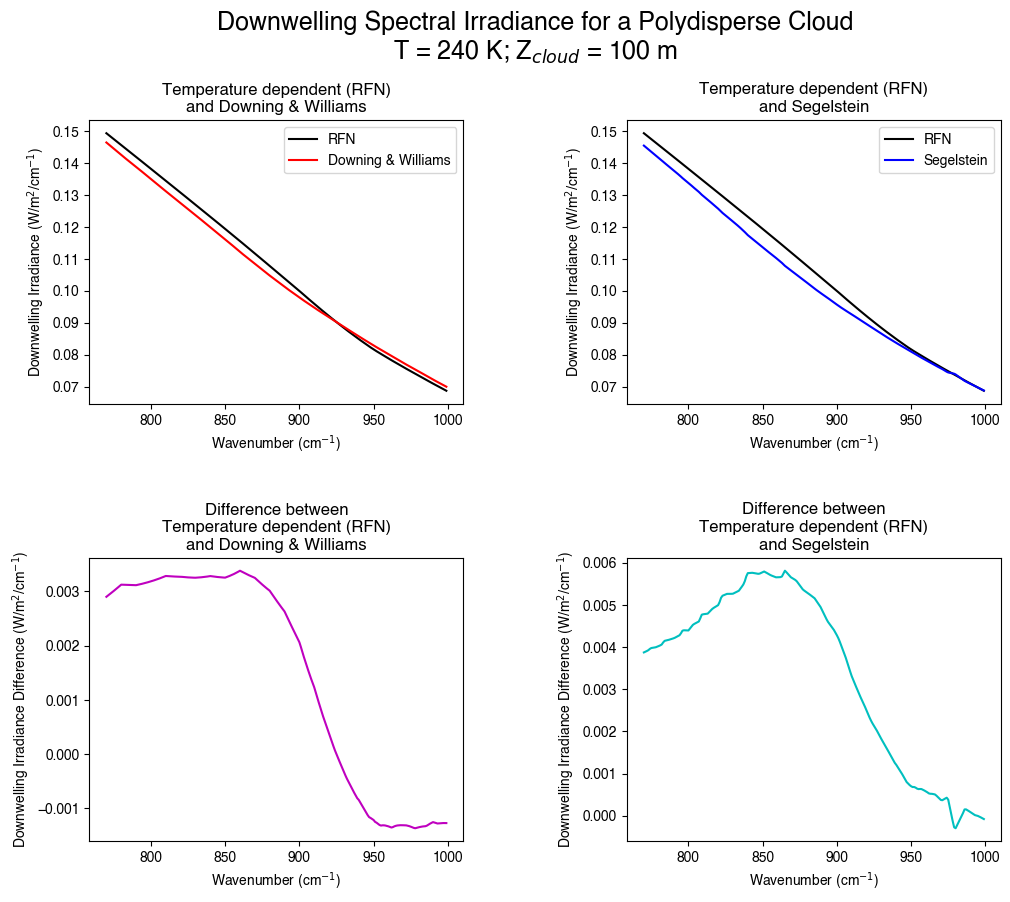

In [15]:
## Graph for T = 240 K
# Set up
fig1, ax_list1 = plt.subplots(2,2)
fig1.set_size_inches(12,10)
fig1.tight_layout(pad=9)

# RFN & Downing
ax_list1[0,0].plot(wvn_range,Down_IR_RFN[0,:],'k',label='RFN')
ax_list1[0,0].plot(wvn_range,Down_IR_DW[0,:],'r',label='Downing & Williams')
ax_list1[0,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list1[0,0].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list1[0,0].set_title('Temperature dependent (RFN)\nand Downing & Williams')
ax_list1[0,0].legend()

# RFN & Segelstein
ax_list1[0,1].plot(wvn_range,Down_IR_RFN[0,:],'k',label='RFN')
ax_list1[0,1].plot(wvn_range,Down_IR_Seg[0,:],'b',label='Segelstein')
ax_list1[0,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list1[0,1].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list1[0,1].set_title('Temperature dependent (RFN)\nand Segelstein')
ax_list1[0,1].legend()

# Difference between RFN & Downing
ax_list1[1,0].plot(wvn_range,(Down_IR_RFN[0,:]-Down_IR_DW[0,:]),'m')
ax_list1[1,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list1[1,0].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list1[1,0].set_title('Difference between\nTemperature dependent (RFN)\nand Downing & Williams')

# Diffrence between RFN & Segelstein
ax_list1[1,1].plot(wvn_range,(Down_IR_RFN[0,:]-Down_IR_Seg[0,:]),'c')
ax_list1[1,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list1[1,1].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list1[1,1].set_title('Difference between\nTemperature dependent (RFN)\nand Segelstein')

fig1.suptitle('Downwelling Spectral Irradiance for a '+type_string+'disperse Cloud\nT = 240 K; Z$_{cloud}$ = '+str(zcloud)+' m',fontsize=18)
fig1.savefig('Spectra240_'+str(zcloud)+'m_'+type_string+'.png',dpi=400)

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/lf/48x517g97453shvbjzhxg9rr0000gp/T/ipykernel_17916/1412637949.py:32: SyntaxWarning: invalid escape sequence '\m'
  secax0.set_xlabel('Wavelength ($\mathrm{\mu}$m)',fontsize=14)
/var/folders/lf/48x517g97453shvbjzhxg9rr0000gp/T/ipykernel_17916/1785901256.py:5: RuntimeWarning: divide by zero encountered in divide
  return 10000/x
/var/folders/lf/48x517g97453shvbjzhxg9rr0000gp/T/ipykernel_17916/1785901256.py:5: RuntimeWarning: divide by zero encountered in divide
  return 10000/x


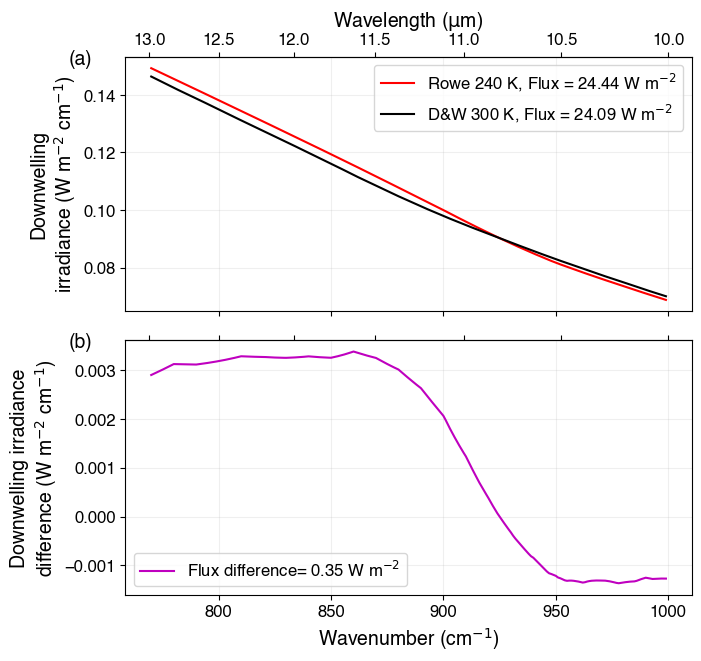

In [16]:
## Graph for T = 240 K
# Set up
fig1 = plt.figure(figsize=(6.9,6.5),layout='constrained')
gs = fig1.add_gridspec(2,1,hspace=0.05)
ax1 = fig1.add_subplot(gs[0])
ax2 = fig1.add_subplot(gs[1])

# RFN & Downing
ax1.plot(wvn_range,Down_IR_RFN[0,:],'r',label='Rowe 240 K, Flux = {:.2f}'.format(Flux_IR_RFN[0])+' W m$^{-2}$')
ax1.plot(wvn_range,Down_IR_DW[0,:],'k',label='D&W 300 K, Flux = {:.2f}'.format(Flux_IR_DW[0])+' W m$^{-2}$')
ax1.set_ylabel('Downwelling\nirradiance (W m$^{-2}$ cm$^{-1}$)',fontsize=14)
#ax1.set_title('Temperature dependent (Rowe)\nand Downing & Williams')
ax1.legend(fontsize=12)
ax1.tick_params(axis='y',labelsize=12)
ax1.tick_params(axis='x',labelbottom=False)
ax1.grid(alpha=0.2)
ax1.text(-0.1,0.97,'(a)',fontsize=14,transform=ax1.transAxes)

# Difference between RFN & Downing
ax2.plot(wvn_range,(Down_IR_RFN[0,:]-Down_IR_DW[0,:]),'m',label='Flux difference= {:.2f}'.format(Flux_IR_RFN[0]-Flux_IR_DW[0])+' W m$^{-2}$')
ax2.set_xlabel('Wavenumber (cm$^{-1}$)',fontsize=14)
ax2.set_ylabel('Downwelling irradiance\ndifference (W m$^{-2}$ cm$^{-1}$)',fontsize=14)
#ax2.set_title('Difference between\nTemperature dependent (Rowe)\nand Downing & Williams')
ax2.legend(fontsize=12)
ax2.tick_params(axis='y',labelsize=12)
ax2.tick_params(axis='x',labelsize=12)
ax2.grid(alpha=0.2)
ax2.text(-0.1,0.97,'(b)',fontsize=14,transform=ax2.transAxes)

# Secondary axis
secax0= ax1.secondary_xaxis('top',functions=(wvn2wvl,wvl2wvn))
secax0.set_xlabel('Wavelength ($\mathrm{\mu}$m)',fontsize=14)
secax0.tick_params(axis='x',labelsize=12)
#ecax0.set_xlim([13,0.05])

secax1= ax2.secondary_xaxis('top',functions=(wvn2wvl,wvl2wvn))
#secax1.set_xlabel('Wavelength ($\mu$m)',fontsize=14)
secax1.tick_params(axis='x',labeltop=False)

#fig1.suptitle('Downwelling Spectral Irradiance for a '+type_string+'disperse Cloud\nT = 240 K; Z$_{cloud}$ = '+str(zcloud)+' m',fontsize=18)
fig1.savefig('Spectra240_'+str(zcloud)+'m_'+type_string+'_DW.pdf',dpi=300,bbox_inches='tight')

Graphs for T = 253 K

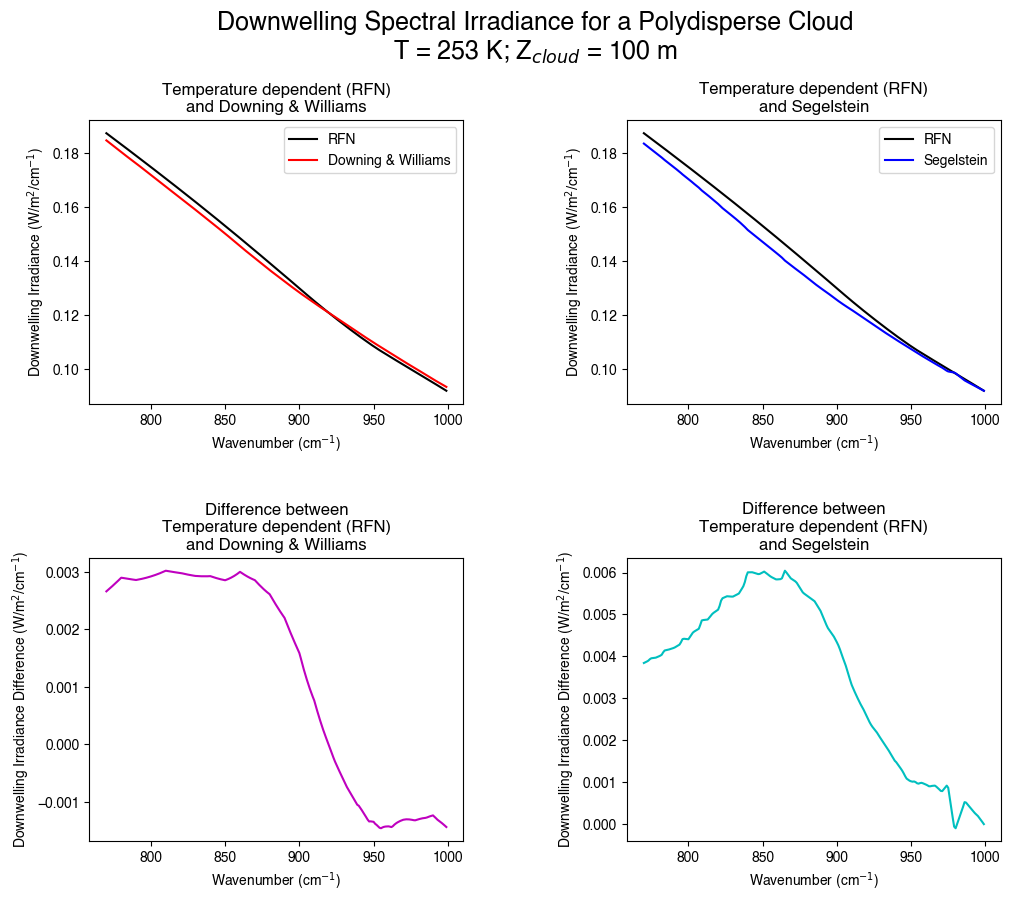

In [17]:
## Graph for T = 253 K
# Set up
fig2, ax_list2 = plt.subplots(2,2)
fig2.set_size_inches(12,10)
fig2.tight_layout(pad=9)

# RFN & Downing
ax_list2[0,0].plot(wvn_range,Down_IR_RFN[1,:],'k',label='RFN')
ax_list2[0,0].plot(wvn_range,Down_IR_DW[1,:],'r',label='Downing & Williams')
ax_list2[0,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list2[0,0].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list2[0,0].set_title('Temperature dependent (RFN)\nand Downing & Williams')
ax_list2[0,0].legend()

# RFN & Segelstein
ax_list2[0,1].plot(wvn_range,Down_IR_RFN[1,:],'k',label='RFN')
ax_list2[0,1].plot(wvn_range,Down_IR_Seg[1,:],'b',label='Segelstein')
ax_list2[0,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list2[0,1].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list2[0,1].set_title('Temperature dependent (RFN)\nand Segelstein')
ax_list2[0,1].legend()

# Difference between RFN & Downing
ax_list2[1,0].plot(wvn_range,(Down_IR_RFN[1,:]-Down_IR_DW[1,:]),'m')
ax_list2[1,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list2[1,0].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list2[1,0].set_title('Difference between\nTemperature dependent (RFN)\nand Downing & Williams')

# Diffrence between RFN & Segelstein
ax_list2[1,1].plot(wvn_range,(Down_IR_RFN[1,:]-Down_IR_Seg[1,:]),'c')
ax_list2[1,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list2[1,1].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list2[1,1].set_title('Difference between\nTemperature dependent (RFN)\nand Segelstein')

fig2.suptitle('Downwelling Spectral Irradiance for a '+type_string+'disperse Cloud\nT = 253 K; Z$_{cloud}$ = '+str(zcloud)+' m',fontsize=18)
fig2.savefig('Spectra253_'+str(zcloud)+'m_'+type_string+'.png',dpi=400)

Graphs for T = 263 K

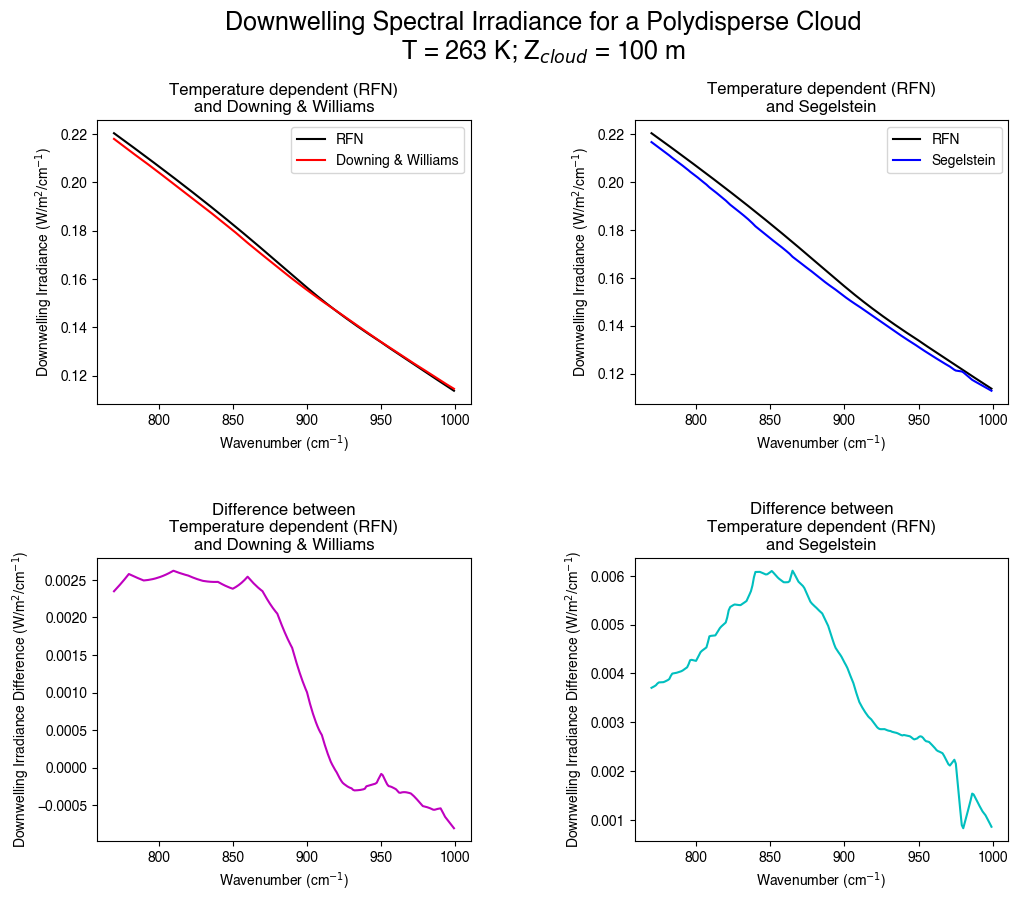

In [18]:
## Graph for T = 263 K
# Set up
fig3, ax_list3 = plt.subplots(2,2)
fig3.set_size_inches(12,10)
fig3.tight_layout(pad=9)

# RFN & Downing
ax_list3[0,0].plot(wvn_range,Down_IR_RFN[2,:],'k',label='RFN')
ax_list3[0,0].plot(wvn_range,Down_IR_DW[2,:],'r',label='Downing & Williams')
ax_list3[0,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list3[0,0].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list3[0,0].set_title('Temperature dependent (RFN)\nand Downing & Williams')
ax_list3[0,0].legend()

# RFN & Segelstein
ax_list3[0,1].plot(wvn_range,Down_IR_RFN[2,:],'k',label='RFN')
ax_list3[0,1].plot(wvn_range,Down_IR_Seg[2,:],'b',label='Segelstein')
ax_list3[0,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list3[0,1].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list3[0,1].set_title('Temperature dependent (RFN)\nand Segelstein')
ax_list3[0,1].legend()

# Difference between RFN & Downing
ax_list3[1,0].plot(wvn_range,(Down_IR_RFN[2,:]-Down_IR_DW[2,:]),'m')
ax_list3[1,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list3[1,0].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list3[1,0].set_title('Difference between\nTemperature dependent (RFN)\nand Downing & Williams')

# Diffrence between RFN & Segelstein
ax_list3[1,1].plot(wvn_range,(Down_IR_RFN[2,:]-Down_IR_Seg[2,:]),'c')
ax_list3[1,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list3[1,1].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list3[1,1].set_title('Difference between\nTemperature dependent (RFN)\nand Segelstein')

fig3.suptitle('Downwelling Spectral Irradiance for a '+type_string+'disperse Cloud\nT = 263 K; Z$_{cloud}$ = '+str(zcloud)+' m',fontsize=18)
fig3.savefig('Spectra263_'+str(zcloud)+'m_'+type_string+'.png',dpi=400)

Graphs for T = 273 K

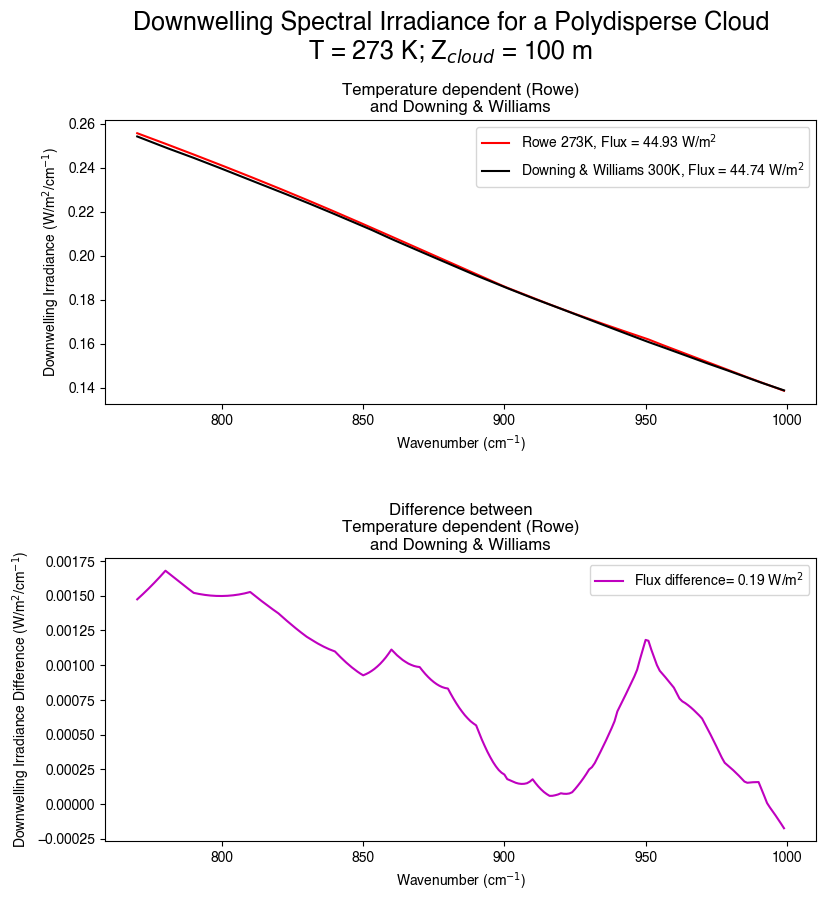

In [19]:
## Graph for T = 273 K
# Set up
fig4, ax_list4 = plt.subplots(2,1)
fig4.set_size_inches(10,10)
fig4.tight_layout(pad=9)

# RFN & Downing
ax_list4[0].plot(wvn_range,Down_IR_RFN[3,:],'r',label='Rowe 273K, Flux = {:.2f}'.format(Flux_IR_RFN[3])+' W/m$^{2}$')
ax_list4[0].plot(wvn_range,Down_IR_DW[3,:],'k',label='Downing & Williams 300K, Flux = {:.2f}'.format(Flux_IR_DW[3])+' W/m$^{2}$')
ax_list4[0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list4[0].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list4[0].set_title('Temperature dependent (Rowe)\nand Downing & Williams')
ax_list4[0].legend()

# Difference between RFN & Downing
ax_list4[1].plot(wvn_range,(Down_IR_RFN[3,:]-Down_IR_DW[3,:]),'m',label='Flux difference= {:.2f}'.format(Flux_IR_RFN[3]-Flux_IR_DW[3])+' W/m$^{2}$')
ax_list4[1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list4[1].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list4[1].set_title('Difference between\nTemperature dependent (Rowe)\nand Downing & Williams')
ax_list4[1].legend()

fig4.suptitle('Downwelling Spectral Irradiance for a '+type_string+'disperse Cloud\nT = 273 K; Z$_{cloud}$ = '+str(zcloud)+' m',fontsize=18)
fig4.savefig('Spectra273_'+str(zcloud)+'m_'+type_string+'_DW.png',dpi=400)

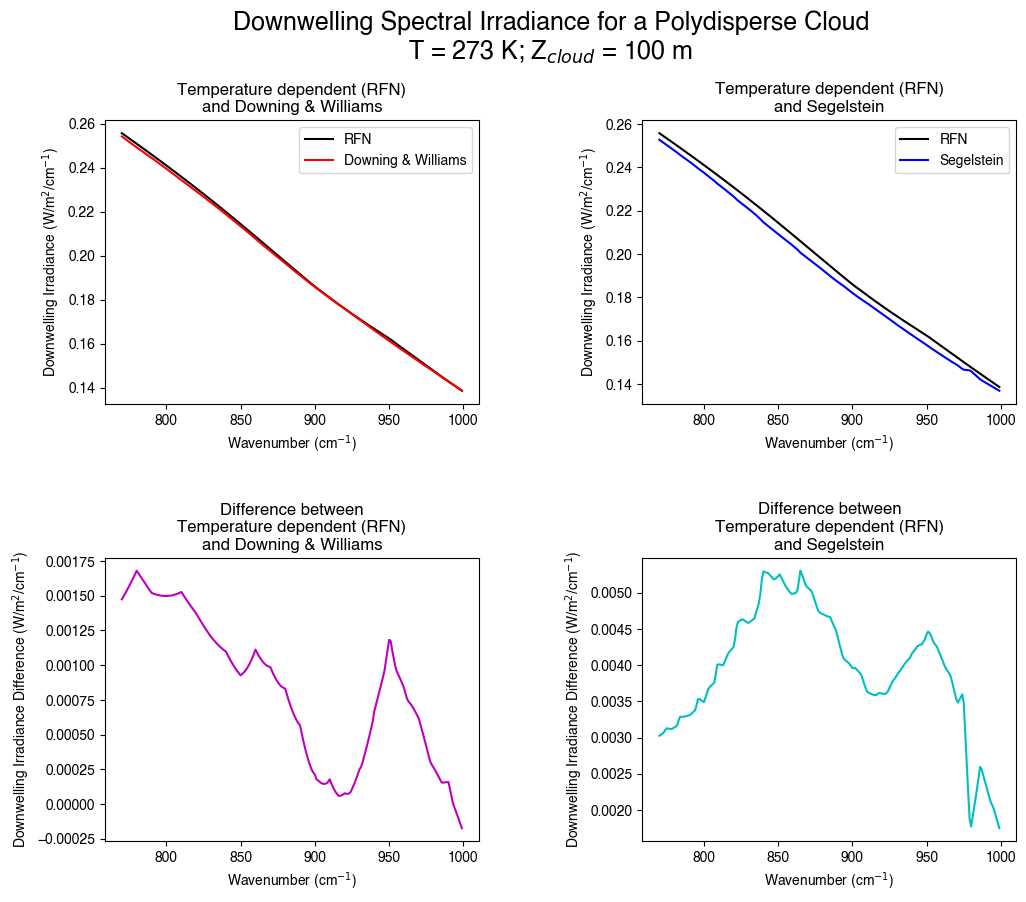

In [20]:
## Graph for T = 273 K
# Set up
fig5, ax_list5 = plt.subplots(2,2)
fig5.set_size_inches(12,10)
fig5.tight_layout(pad=9)

# RFN & Downing
ax_list5[0,0].plot(wvn_range,Down_IR_RFN[3,:],'k',label='RFN')
ax_list5[0,0].plot(wvn_range,Down_IR_DW[3,:],'r',label='Downing & Williams')
ax_list5[0,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list5[0,0].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list5[0,0].set_title('Temperature dependent (RFN)\nand Downing & Williams')
ax_list5[0,0].legend()

# RFN & Segelstein
ax_list5[0,1].plot(wvn_range,Down_IR_RFN[3,:],'k',label='RFN')
ax_list5[0,1].plot(wvn_range,Down_IR_Seg[3,:],'b',label='Segelstein')
ax_list5[0,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list5[0,1].set_ylabel('Downwelling Irradiance (W/m$^{2}$/cm$^{-1}$)')
ax_list5[0,1].set_title('Temperature dependent (RFN)\nand Segelstein')
ax_list5[0,1].legend()

# Difference between RFN & Downing
ax_list5[1,0].plot(wvn_range,(Down_IR_RFN[3,:]-Down_IR_DW[3,:]),'m')
ax_list5[1,0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list5[1,0].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list5[1,0].set_title('Difference between\nTemperature dependent (RFN)\nand Downing & Williams')

# Diffrence between RFN & Segelstein
ax_list5[1,1].plot(wvn_range,(Down_IR_RFN[3,:]-Down_IR_Seg[3,:]),'c')
ax_list5[1,1].set_xlabel('Wavenumber (cm$^{-1}$)')
ax_list5[1,1].set_ylabel('Downwelling Irradiance Difference (W/m$^{2}$/cm$^{-1}$)')
ax_list5[1,1].set_title('Difference between\nTemperature dependent (RFN)\nand Segelstein')

fig5.suptitle('Downwelling Spectral Irradiance for a '+type_string+'disperse Cloud\nT = 273 K; Z$_{cloud}$ = '+str(zcloud)+' m',fontsize=18)
fig5.savefig('Spectra273_'+str(zcloud)+'m_'+type_string+'.png',dpi=400)

## Analysis 

### Effect of Cloud Temperature

In [21]:
Image(url= "Spectra240_100m_Mono.png", width=700, height=600)

Figure 1. Downwelling spectra from a monodisperse cloud with thickness of 100 m and temperature of 240 K. (upper left) Downwelling spectral irradiance for temperature dependent (RFN) CRI and Downing & Williams (D&W) CRI. (upper right) Downwelling spectral irradiance for RFN CRI and Segelstein CRI. (lower left) Difference in spectral irradiance for RFN & D&W CRI. (lower right) Difference in spectral irradiance for RFN & Segelstein CRI.

In [22]:
Image(url= "Spectra253_100m_Mono.png", width=700, height=600)

Figure 2. Downwelling spectra from a monodisperse cloud with thickness of 100 m and temperature of 253 K. (upper left) Downwelling spectral irradiance for temperature dependent (RFN) CRI and Downing & Williams (D&W) CRI. (upper right) Downwelling spectral irradiance for RFN CRI and Segelstein CRI. (lower left) Difference in spectral irradiance for RFN & D&W CRI. (lower right) Difference in spectral irradiance for RFN & Segelstein CRI.

In [23]:
Image(url= "Spectra263_100m_Mono.png", width=700, height=600)

Figure 3. Downwelling spectra from a monodisperse cloud with thickness of 100 m and temperature of 263 K. (upper left) Downwelling spectral irradiance for temperature dependent (RFN) CRI and Downing & Williams (D&W) CRI. (upper right) Downwelling spectral irradiance for RFN CRI and Segelstein CRI. (lower left) Difference in spectral irradiance for RFN & D&W CRI. (lower right) Difference in spectral irradiance for RFN & Segelstein CRI.

In the Figures 1-3, the temperature of the cloud increases from 240 K to 263 K. For all the above cases, the temperature dependent (RFN) CRI produce a higher downwelling irradiance than any of the temperature independent CRI (D&W or Segelstein), as expceted. As the temperature increases, the difference between the RFN CRI spectra (black) and the temperature independent CRI (D&W - red, Segelstein - blue) decreases. This is likely because as the temperature of the cloud approaches the temperature at which the temperature independent CRI were measured at, their downwelling irradiance spectra become more accurate.

### Polydisperse vs Monodisperse Cloud

In [24]:
Image(url= "Spectra240_100m_Poly.png", width=700, height=600)

Figure 4. Downwelling spectra from a polydisperse cloud with thickness of 100 m and temperature of 240 K. (upper left) Downwelling spectral irradiance for temperature dependent (RFN) CRI and Downing & Williams (D&W) CRI. (upper right) Downwelling spectral irradiance for RFN CRI and Segelstein CRI. (lower left) Difference in spectral irradiance for RFN & D&W CRI. (lower right) Difference in spectral irradiance for RFN & Segelstein CRI.

In the Figures 1 and 4, the polydisperse cloud generates a lower downwelling irradiance value than the monodisperse cloud. However, the polydisperse cloud does create a larger difference in downwelling irradiance between the temperature dependent CRI and the temperature independent CRI. 

### Effect of Cloud Thickness

In [25]:
Image(url= "Spectra240_500m_Mono.png", width=700, height=600)

Figure 5. Downwelling spectra from a monodisperse cloud with thickness of 500 m and temperature of 240 K. (upper left) Downwelling spectral irradiance for temperature dependent (RFN) CRI and Downing & Williams (D&W) CRI. (upper right) Downwelling spectral irradiance for RFN CRI and Segelstein CRI. (lower left) Difference in spectral irradiance for RFN & D&W CRI. (lower right) Difference in spectral irradiance for RFN & Segelstein CRI.

In [26]:
Image(url= "Spectra240_1000m_Mono.png", width=700, height=600)

Figure 6. Downwelling spectra from a monodisperse cloud with thickness of 1000 m and temperature of 240 K. (upper left) Downwelling spectral irradiance for temperature dependent (RFN) CRI and Downing & Williams (D&W) CRI. (upper right) Downwelling spectral irradiance for RFN CRI and Segelstein CRI. (lower left) Difference in spectral irradiance for RFN & D&W CRI. (lower right) Difference in spectral irradiance for RFN & Segelstein CRI.

In the Figures 1, 5, and 6, the thickness of the cloud increases from 100 m to 1000 m. For all the above cases, the temperature dependent (RFN) CRI generally produce a higher downwelling irradiance than any of the temperature independent CRI (D&W or Segelstein), as expceted. However, as the cloud thicnkess increases from 100 to 500 m, the difference between the RFN CRI spectra (black) and the temperature independent CRI (D&W - red, Segelstein - blue) shrinks to almost nothing. Cloud thicknesses of 500 m and 1000 m produce almost identical spectra. This is likely because as the thickness of the cloud increases, it becomes a more blackbody and the CRI type that determines the emissivity of the cloud does not matter anymore as the emissivity approaches 1.

## Conclusions
From this project, we can confirm the prior results from Antarctica and say that the temperature dependent CRIs produce higher downwelling flux for supercooled liquid clouds. We can even see the effect in a two-stream model. From my experiments, this effect is lessened the closer the cloud is to room temperature because the temperature independent CRI become more accurate. Next, adding a number distribution and turning the cloud from monodisperse to polydisperse decreases the radiation emitted from the cloud but increases the effect of the temperature dependent CRIs. Finally, increasing cloud thickness reduces the effect of the temperature dependent CRIs as the cloud starts to approximate a black body. This result shows that the temperature dependent CRIs only matter for optically thin clouds with supercooled liquid water. This was a proof-of-concept project for my research this summer, when I will start adding temperature dependent CRIs to the single-column model for CESM to test this effect in an Arctic test case. Eventually, I will add these CRIs to the full CESM to test their effect across the entire Arctic because currently, climate models only use temperature independent (aka room temperature) CRIs for liquid water and may be underestimating downwelling infrared radiation from supercooled liquid clouds in the Arctic.

## References
Downing, H. D., & Williams, D. (1975). Optical constants of water in the infrared. Journal of Geophysical Research, 80(12), 1656–1661.

Rowe, P. M., Fergoda, M., and Neshyba, S., Temperature‐Dependent Optical Properties of Liquid Water From 240 to 298 K. J. Geophys. Res. Atmos., 125(17), e2020JD032624, 2020.

Segelstein, D., The Complex Refractive Index of Water, M.S. Thesis, University of Missouri, Kansas City, 1981.